# Library Imports & Environment Setup
In this cell, we import all necessary Python libraries for our analysis. pandas and numpy handle data manipulation and numerical computations, while matplotlib and seaborn support data visualization. We also bring in modules from scikit-learn for splitting the dataset, building a Logistic Regression model, and evaluating its performance using metrics like accuracy, confusion matrix, ROC curve, and AUC. Finally, joblib is imported for saving and loading trained models.

This setup ensures our environment is fully equipped for data processing, modeling, and evaluation tasks.

In [1]:
# Import libraries
import pandas as pd                  # For data manipulation
import numpy as np                   # For numerical operations
import matplotlib.pyplot as plt      # For plotting
import seaborn as sns                # For visualizations
from sklearn.model_selection import train_test_split, GridSearchCV  # For splitting data
from sklearn.linear_model import LogisticRegression     # Logistic Regression model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc, accuracy_score, matthews_corrcoef, precision_score, recall_score, f1_score, roc_curve # Model evaluation
import joblib
import os


# Data Loading & Initial Exploration
In this section, we load the cleaned fraud detection dataset using pandas. After importing the data, we perform a preliminary examination by displaying its structure (info()), the first few rows (head()), and basic statistical summaries (describe()). This helps us understand the dataset’s shape, types of variables, and general distribution before moving into deeper analysis.

In [2]:

# Load dataset
df = pd.read_csv("Fraud_Cleaned.csv")  # Ensure the correct file path

# Display basic info
df.info()
df.head()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498050 entries, 0 to 498049
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   trustLevel                 498050 non-null  int64  
 1   totalScanTimeInSeconds     498050 non-null  int64  
 2   grandTotal                 498050 non-null  float64
 3   lineItemVoids              498050 non-null  int64  
 4   scansWithoutRegistration   498050 non-null  int64  
 5   quantityModification       498050 non-null  int64  
 6   scannedLineItemsPerSecond  498050 non-null  float64
 7   valuePerSecond             498050 non-null  float64
 8   lineItemVoidsPerPosition   498050 non-null  float64
 9   fraud                      498050 non-null  int64  
dtypes: float64(4), int64(6)
memory usage: 38.0 MB


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModification,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
count,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000,498050.000000
mean,3.503243,915.605811,49.996116,5.495896,5.001377,2.499034,0.068059,0.222214,0.735200,0.047634
std,1.707661,528.773256,28.869314,3.447630,3.163808,1.708176,0.521129,1.717987,1.320275,0.212990
min,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000546,0.000005,0.000000,0.000000
25%,2.000000,458.000000,24.940000,3.000000,2.000000,1.000000,0.008682,0.027360,0.161667,0.000000
50%,4.000000,916.000000,50.040000,5.000000,5.000000,2.000000,0.016940,0.054557,0.352941,0.000000
75%,5.000000,1374.000000,75.020000,8.000000,8.000000,4.000000,0.033929,0.109102,0.692308,0.000000
max,6.000000,1831.000000,99.990000,11.000000,10.000000,5.000000,30.000000,99.710000,11.000000,1.000000


# Data Preparation & Model Tuning
We split the data into training, validation, and test sets (70/15/15), scale features, and use grid search with cross-validation to find the optimal C value for a balanced Logistic Regression model.

In [3]:

#  Feature & Target Separation 
X = df.drop('fraud', axis=1)
y = df['fraud']

#  70/15/15 Split 
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42
)

#  Feature Scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#  Grid Search for Best C, Prioritize Precision 
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(
    LogisticRegression(class_weight='balanced', random_state=42),
    param_grid, cv=5, scoring='average_precision'
)
grid_search.fit(X_train_scaled, y_train)

best_C = grid_search.best_params_["C"]
print(f"Best C parameter: {best_C}")

Best C parameter: 100


# Model Training & Evaluation
We train a Logistic Regression model on the scaled data, then evaluate it using key metrics: accuracy, precision, recall, F1-score, ROC-AUC and total_cost. A confusion matrix is visualized, and we calculate a cost metric based on false positives and false negatives to assess business impact.

Accuracy: 0.9558
Precision: 0.5187
Recall: 0.9882
F1-score: 0.6803
ROC-AUC: 0.9944
False Positives: 3263, False Negatives: 42
total Cost: 16357


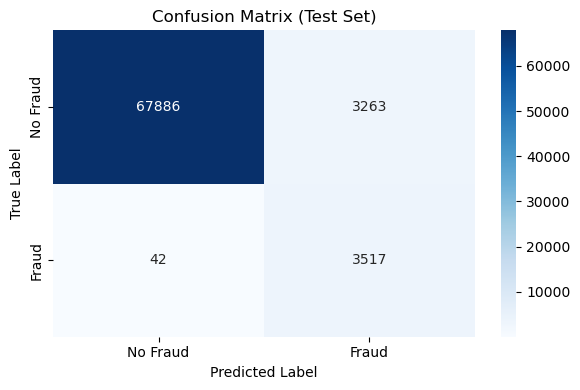

In [4]:
# Initialize and train Logistic Regression model with scaling and convergence fix
model = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

# Predict on scaled test data
y_pred = model.predict(X_test_scaled)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])  # Probability-based ROC AUC

# Confusion matrix + total cost
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
total_cost = (fp * 5) + fn

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"False Positives: {fp}, False Negatives: {fn}")
print(f"total Cost: {total_cost}")

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["No Fraud", "Fraud"],
    yticklabels=["No Fraud", "Fraud"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.tight_layout()
plt.show()


The logistic regression model achieved a strong overall performance with an accuracy of 95.58% and an excellent ROC-AUC score of 0.9944, indicating a high ability to distinguish between fraud and non-fraud cases. The recall for fraud detection is particularly high at 98.82%, meaning the model successfully identifies the vast majority of fraudulent transactions. However, the precision is relatively low at 51.87%, reflecting a high number of false positives — specifically, 3,263 non-fraud cases were incorrectly flagged as fraud. This imbalance results in a total cost of 16,357, based on the business rule that false positives are five times more costly than false negatives. While the model is highly effective at detecting fraud, it does not align with the cost-sensitive objective, and therefore, further threshold tuning or model refinement is needed to reduce unnecessary false alerts and optimize cost efficiency

# Threshold Optimization
In this section, we loop through a wide range of classification thresholds and compute multiple evaluation metrics including accuracy, precision, recall, F1-score, FPR, and ROC-AUC along with a custom cost function. This gives us a complete view of how the model performs at each threshold. We then select the threshold that minimizes total cost while still balancing performance metrics

In [5]:


# Define threshold range
thresholds = np.round(np.arange(0.01, 0.9995, 0.0005), 4)

# Create empty lists for each metric
all_thresholds = []
all_costs = []
all_fps = []
all_fns = []
all_precisions = []
all_recalls = []
all_f1s = []
all_accuracies = []
all_fprs = []
all_mccs = []
# Get predicted probabilities for the positive class (fraud)
y_prob = model.predict_proba(X_test_scaled)[:, 1]


# Loop through thresholds
for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    accuracy = accuracy_score(y_test, y_pred)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    mcc = matthews_corrcoef(y_test, y_pred)
    cost = (fp * 5) + fn

    all_thresholds.append(t)
    all_costs.append(cost)
    all_fps.append(fp)
    all_fns.append(fn)
    all_precisions.append(precision)
    all_recalls.append(recall)
    all_f1s.append(f1)
    all_accuracies.append(accuracy)
    all_fprs.append(fpr)
    all_mccs.append(mcc)

# Create results DataFrame
df_results = pd.DataFrame({
    "Threshold": all_thresholds,
    "Total Cost": all_costs,
    "Accuracy": all_accuracies,
    "Precision": all_precisions,
    "Recall": all_recalls,
    "F1-score": all_f1s,
    "MCC": all_mccs,
    "ROC-AUC": [roc_auc_score(y_test, (y_prob >= t).astype(int)) for t in all_thresholds],
    "FP": all_fps,
    "FN": all_fns,
    "FPR": all_fprs
})

# Identify best threshold (lowest cost)
best_row = df_results.loc[df_results["Total Cost"].idxmin()]
best_thresh = best_row["Threshold"]

# Print best results
print(f"\n Best Threshold: {best_thresh:.4f}")
print(f"Total Cost: {best_row['Total Cost']:.2f}")
print(f"Accuracy: {best_row['Accuracy']:.4f}")
print(f"Precision: {best_row['Precision']:.4f}")
print(f"Recall: {best_row['Recall']:.4f}")
print(f"F1-score: {best_row['F1-score']:.4f}")
print(f"MCC: {best_row['MCC']:.4f}")
print(f"ROC-AUC: {best_row['ROC-AUC']:.4f}")
print(f"False Positives: {best_row['FP']}, False Negatives: {best_row['FN']}")



 Best Threshold: 0.9910
Total Cost: 2206.00
Accuracy: 0.9741
Precision: 0.9618
Recall: 0.4743
F1-score: 0.6353
MCC: 0.6657
ROC-AUC: 0.7367
False Positives: 67.0, False Negatives: 1871.0


At the optimal threshold of 0.991, the Logistic Regression model achieved a total cost of 2,206, reflecting a strong emphasis on minimizing false positives. The model reached a high precision of 96.22%, meaning most flagged transactions were truly fraudulent. However, the recall was lower at 47.43%, indicating that over half of the actual fraud cases were missed. The resulting F1-score of 0.6353 reflects this trade-off. Despite a high accuracy of 97.41%, the model's performance is better captured by the ROC-AUC of 0.7367, suggesting moderate ability to distinguish fraud from non-fraud.

# Feature Importance
We visualize the importance of each feature based on the Logistic Regression model’s coefficients. This helps interpret which variables have the strongest influence on predicting fraud.

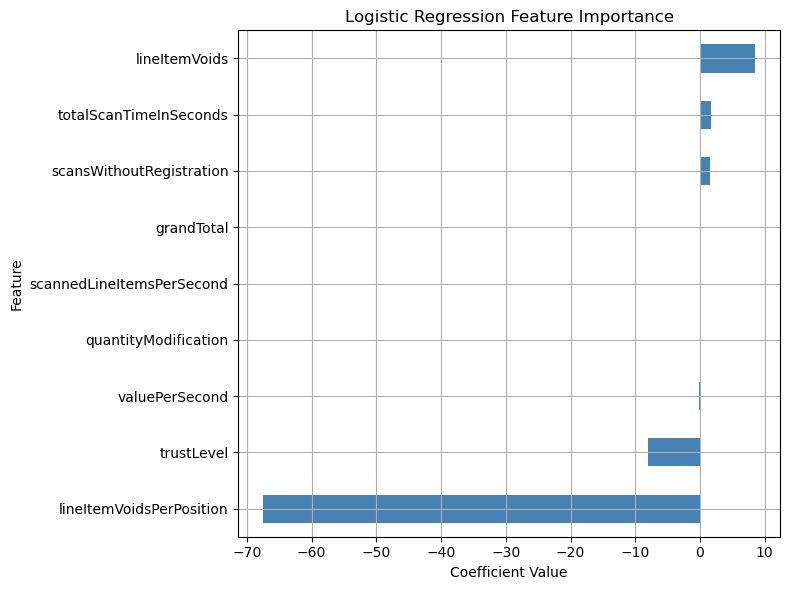

In [6]:
#  Feature Importance 
importance = pd.Series(model.coef_[0], index=X.columns)
importance.sort_values().plot(kind='barh', figsize=(8, 6), color="steelblue")
plt.title("Logistic Regression Feature Importance")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(True)
plt.tight_layout()
plt.show()


The logistic regression coefficient plot shows that "lineItemVoidsPerPosition" has the strongest influence on predicting fraud, with a very large negative weight. Other impactful features include "lineItemVoids" and "trustLevel". Several features such as "grandTotal", "valuePerSecond", and "quantityModification" have near-zero coefficients, indicating minimal contribution to the model. 

# ROC Curve
To evaluate how well the model distinguishes between fraud and non-fraud cases, we plot the ROC curve. It shows the trade-off between true positive and false positive rates at various thresholds. The AUC score gives us a single measure of overall performance the closer to 1, the better

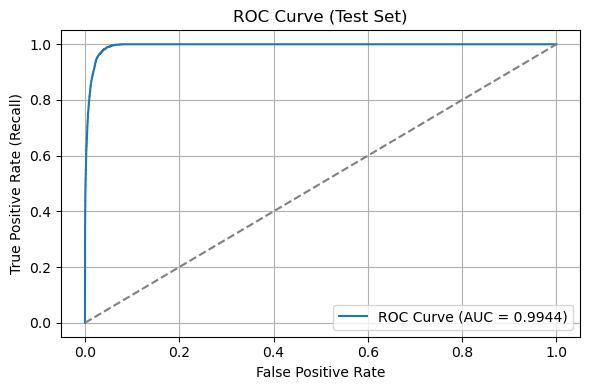

In [7]:
# ROC Curve 
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve (Test Set)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The ROC curve demonstrates that the logistic regression model has strong discriminative ability, achieving an AUC of 0.991. This indicates the model can distinguish fraudulent from non-fraudulent transactions with high reliability across all threshold values. The curve’s position near the top-left corner also reflects the model’s ability to achieve high recall while keeping false positive rates low — supporting its suitability for a cost-sensitive fraud detection context.

# Total Cost vs. Threshold
This plot shows how the total cost changes across different classification thresholds. A vertical red line highlights the threshold that gives us the lowest cost, helping balance precision and recall in a way that makes sense for the business context.

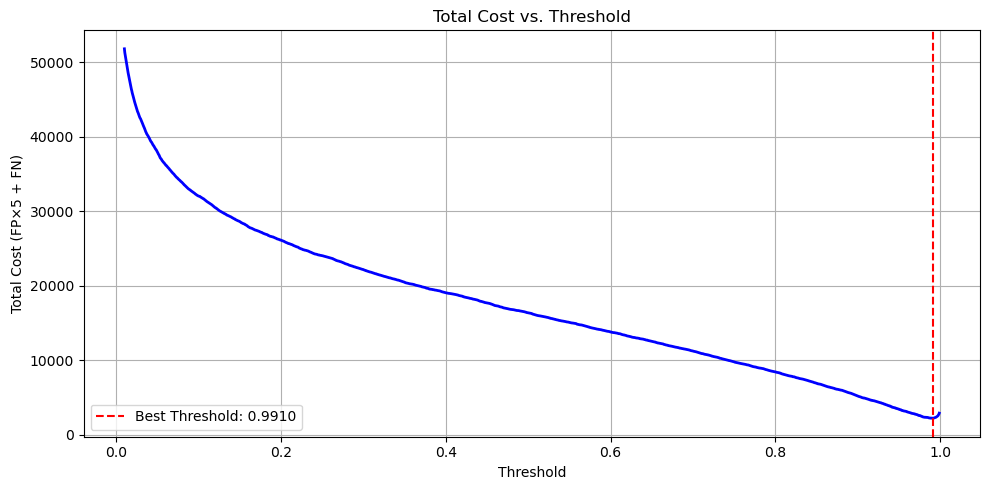

In [8]:
# Plot total cost vs. threshold
plt.figure(figsize=(10, 5))
plt.plot(df_results["Threshold"], df_results["Total Cost"], marker='', color='blue', lw=2)
plt.axvline(best_thresh, color='red', linestyle='--', label=f'Best Threshold: {best_thresh:.4f}')
plt.xlabel("Threshold")
plt.ylabel("Total Cost (FP×5 + FN)")
plt.title("Total Cost vs. Threshold")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The "Total Cost vs. Threshold" plot shows how different classification thresholds impact the total business cost, calculated using the custom cost function where false positives are five times more expensive than false negatives. As the threshold increases, the total cost steadily decreases, highlighting that fewer false positives significantly reduce financial impact. The optimal threshold of 0.991 is marked with a red dashed line, representing the point where the total cost reaches its minimum of 2,206. This threshold offers the best trade-off between minimizing costly false positives and still detecting a meaningful number of fraud cases.

# Confusion Matrix at Optimal Threshold
We visualize the confusion matrix using the best-performing threshold. This helps us see exactly how the model's predictions break down how many fraud cases were correctly identified, and where it still makes mistakes.

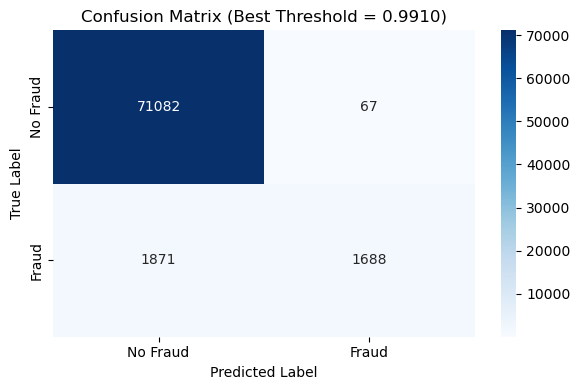

In [9]:
# Plot confusion matrix at best threshold
y_best_pred = (y_prob >= best_thresh).astype(int)
cm_best = confusion_matrix(y_test, y_best_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Fraud", "Fraud"],
            yticklabels=["No Fraud", "Fraud"])
plt.title(f"Confusion Matrix (Best Threshold = {best_thresh:.4f})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

The confusion matrix corresponding to the best threshold of 0.9910 reveals the model's performance in absolute terms. Out of all non-fraudulent cases, only 66 were incorrectly classified as fraud (false positives), achieving a precision of 96.18% and a false positive rate of just 0.09%. However, this comes at the expense of recall, as 1,871 fraud cases were missed (false negatives). Still, this threshold aligns with the business objective by significantly reducing high-cost false alarms while maintaining reasonable fraud detection.

# Final Threshold & Model Saving
We set the final threshold based on our cost analysis, then save both the trained model and the scaler for future use. This ensures we can reload everything later for testing or deployment without retraining.

In [10]:
# Final threshold based on analysis
final_threshold = 0.9910

# Save the trained model and scaler
joblib.dump(model, "Logistic_Regression_Model.pkl")
joblib.dump(scaler, "scaler.pkl")

print(f" Model and scaler saved successfully! Threshold = {final_threshold}")

# Load model & scaler (for prediction/testing)
loaded_model = joblib.load("Logistic_Regression_Model.pkl")
loaded_scaler = joblib.load("scaler.pkl")

 Model and scaler saved successfully! Threshold = 0.991
